# LLM - Detect AI Generated Text

In the past few years, significant advancements have been made in the development of large language models (LLMs). These models have reached a level of sophistication where the text they generate closely resembles that of human authors. This notebook explores machine learning models that can effectively determine whether an essay was authored by a student or generated by a large language model. 

The dataset includes a mixture of essays composed by students and those produced by various LLMs. For each id in the test set, predict a probability that that essay was generated. Results are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Acknowledgments

Vanderbilt University and the Learning Agency Lab would like to thank the Bill & Melinda Gates Foundation, Schmidt Futures, and Chan Zuckerberg Initiative for their support in making this work possible.

Jules King, Perpetual Baffour, Scott Crossley, Ryan Holbrook, Maggie Demkin. (2023). LLM - Detect AI Generated Text. Kaggle. https://kaggle.com/competitions/llm-detect-ai-generated-text

# Table of Contents

- [Imports](#imports)
- [Load Data](#load-data)
- [EDA Summary](#eda-summary)
- [EDA](#eda)

<a id="imports"></a>
# Imports

In [1]:
# Imports for Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Imports for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for Text Analysis and NLP
from wordcloud import WordCloud
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords, cmudict, words
from nltk.metrics import BigramAssocMeasures
from nltk.util import ngrams
import string
import re
from collections import Counter, defaultdict
import itertools
from itertools import chain
from textblob import TextBlob

# Imports for Machine Learning and Text Processing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

# Downloads for NLTK
nltk.download('punkt')
nltk.download('cmudict')
nltk.download("words")

# Load the Dale-Chall word list
dale_chall_word_list = set(words.words())

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Load the pronunciation dictionary
prondict = cmudict.dict()

# Check library versions
print(f"Spacy version: {spacy.__version__}")
print(f"NLTK version: {nltk.__version__}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /usr/share/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
Spacy version: 3.6.1
NLTK version: 3.2.4


<a id="load"></a>
# Load Data

{test|train}_essays.csv
- `id` - A unique identifier for each essay.
- `prompt_id` - Identifies the prompt the essay was written in response to.
- `text` - The essay text itself.
- `generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

train_prompts.csv - Essays were written in response to information in these fields.
- `prompt_id` - A unique identifier for each prompt.
- `prompt_name` - The title of the prompt.
- `instructions` - The instructions given to students.
- `source_text` - The text of the article(s) the essays were written in response to, in Markdown format. Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in `0 Paragraph one.\n\n1 Paragraph two.`. Essays sometimes refer to a paragraph by its numeral. Each article is preceded with its title in a heading, like `# Title`. When an author is indicated, their name will be given in the title after by. Not all articles have authors indicated. An article may have subheadings indicated like `## Subheading`.

In [2]:
train_prompts = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
sample_submission = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
# Load the training and testing datasets
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

<a id="eda-summary"></a>
# EDA Summary

## Dataset Summary

- `train_essays.csv` (row count=1378) file reveals a significant class imbalance, with student-written essays far outnumbering those generated by LLMs (3 essays, 2 from prompt_id=1, 1 from prompt_id=0)
- `test_essays.csv` (row count=3): Aligns with the training set but lacks target labels. Use for submission.
- `train_prompts.csv` (row count=2): Contains only 2 distinct prompts, each with unique instructions and source texts (that may influencing essay styles)
- `sample_submission.csv`: The expected format for model predictions to be evaluated.

<span style="color:red">TODO: Fix values for these, and add extra statistics</span>.
## Student-Written Essays:

- Median word length: 4.69 characters
- Median unique word count: 251.0 unique words
- Median word count: 525.0 words
- Median stop word count: 250.0 words
- Median sentence count: 27 sentences
- Median clause count: 22.54 clauses
- Median TTR: 0.43
- Median paragraph count: 5.6 paragraphs


## LLM-Generated Essays:

- Median word length: 4.82 characters
- Median unique word count: 117.0 unique words
- Median word count: 258.0 words
- Median stop word count: 124.0 words
- Median sentence count: 11 sentences
- Median clause count: 23.18 clauses
- Median TTR: 0.47
- Median paragraph count: 11 paragraphs

<a id="train-prompts"></a>
## train_prompts

There are 2 prompts provided in `train_prompts`, each with a question, instructions, and 3-4 reading passages to serve as source texts.

In [3]:
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


<a id="train-essays"></a>
## train_essays

- No missing values
- 1378 essays, of which 3 are generated 

In [4]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
# 1378 essays in total
train_essays.shape

(1378, 4)

In [6]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


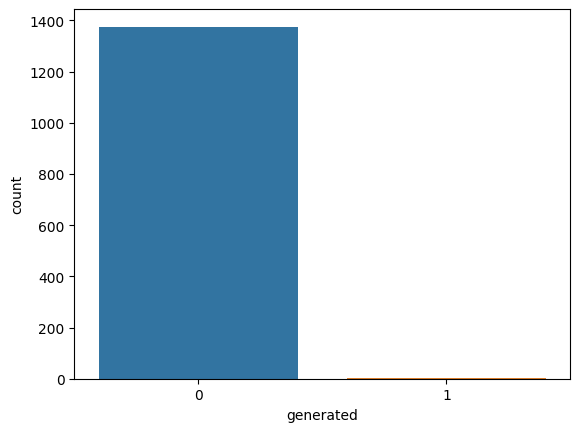

In [7]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

## test_essays

In [8]:
test_essays

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


## sample_submission

In [9]:
sample_submission

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


<a id="eda"></a>
# EDA
<span style="color:red">TODO: Fill in ToC for EDA</span>.
- [Word Cloud](#word-cloud)
- [Average Word Length](#average-word-length)
- [Unique Words](#unique-words)
- [Word Count](#word-count)
- [Most Common Words](#most-common-words)
- [Stop Word Count](#stop-word-count)
- [Number of Sentences](#sentence-count)
- [Number of Clauses](#clause-count)
- [Vocabulary Richness](#vocabulary-richness)
- [Number of Paragraphs](#paragraph-count)
- [Digit Representation](#digit-representation)
- [Readability Measures](#readability-measures)
- [Parts of Speech](#parts-of-speech)
- [NER](#ner)
- [Semantic Analysis](#semantic-analysis)
- [Topic Modeling](#topic-modeling)
- [Sentiment Polarity](#sentiment-polarity)

<a id="word-cloud"></a>
## Word Cloud

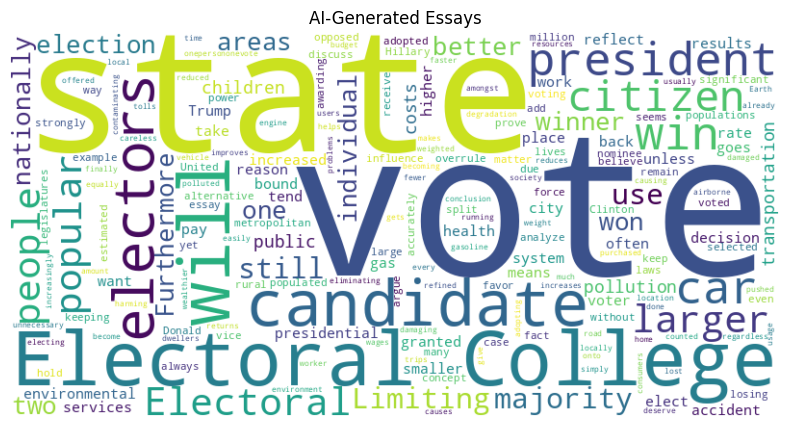

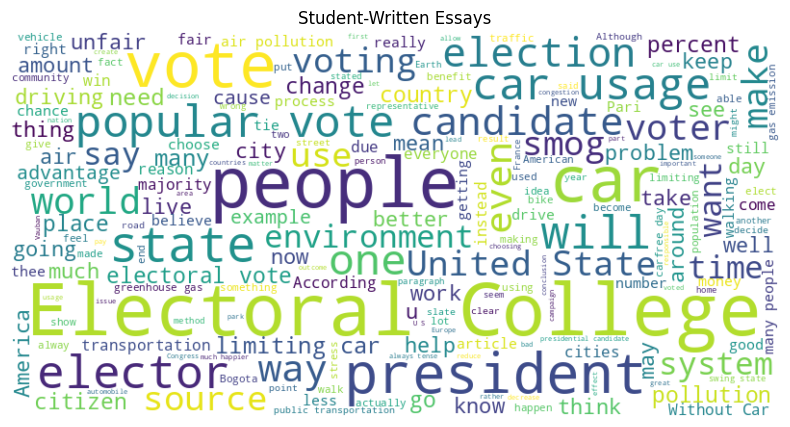

In [10]:
# Separate AI-generated and student-written essays
ai_generated_essays = train_essays[train_essays['generated'] == 1]
student_essays = train_essays[train_essays['generated'] == 0]

# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create word clouds for AI-generated and student-written essays
generate_wordcloud(" ".join(ai_generated_essays['text']), "AI-Generated Essays")
generate_wordcloud(" ".join(student_essays['text']), "Student-Written Essays")

<a id="average-word-length"></a>
## Average Word Length

- Median word length for student essays: 4.69 characters
- Median word length for llm-generated essays: 4.82 characters
- Non-generated essays have a wider distribution of median word length and outliers depicted as individual points outside the boxes

,generated,avg_word_length
0,0,4.69
1,1,4.82


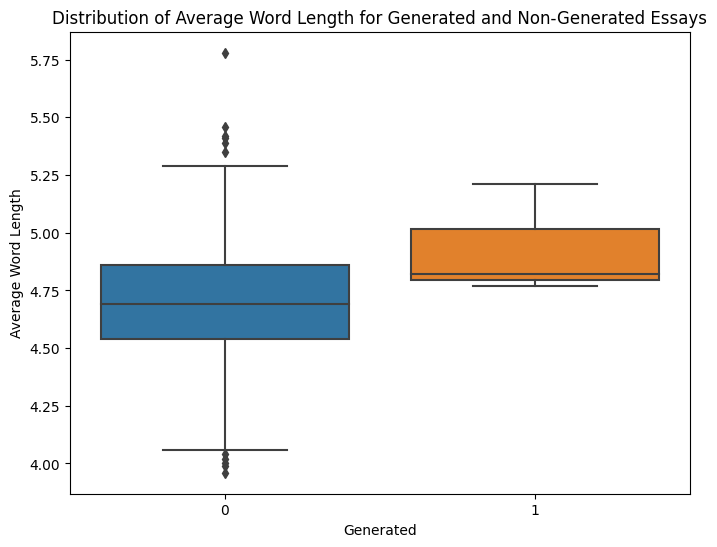

In [11]:
# Define a function to calculate the average word length
def average_word_length(text):
    words = text.split()
    total_word_length = sum(len(word) for word in words)
    return round(total_word_length / len(words), 2)

# Apply the function to create a new 'avg_word_length' column
train_essays['avg_word_length'] = train_essays['text'].apply(average_word_length)

# Calculate the median average word length for generated and non-generated essays
median_avg_word_length = train_essays.groupby(['generated'])['avg_word_length'].median().reset_index()
display(median_avg_word_length)

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(x='generated', y='avg_word_length', data=train_essays)
plt.title('Distribution of Average Word Length for Generated and Non-Generated Essays')
plt.xlabel('Generated')
plt.ylabel('Average Word Length')
plt.show()

<a id="unique-words"></a>
## Unique words

- Median unique word count for student essays: 251.0 words
- Median unique word count for llm-generated essays: 117.0 words
- Non-generated essays have a wider distribution of median unique word count and outliers depicted as individual points outside the boxes

,generated,uniq_word_count
0,0,251.0
1,1,117.0


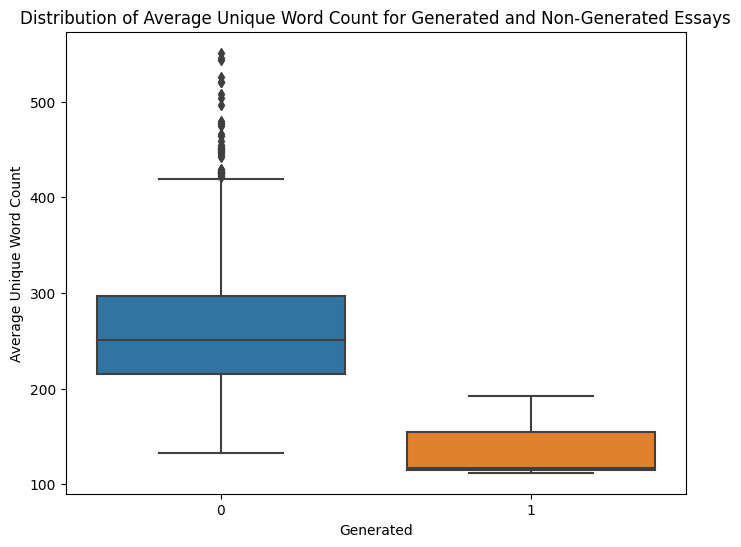

In [12]:
# Define a function to calculate the number of unique words
def nr_unique_words(text):
    words = text.split()
    unique_words = set(word.lower() for word in words)
    return len(unique_words)

# Apply the function to create a new 'uniq_word_count' column
train_essays['uniq_word_count'] = train_essays['text'].apply(nr_unique_words)

# Calculate the median unique word count for generated and non-generated essays
median_word_count = train_essays.groupby(['generated'])['uniq_word_count'].median().reset_index()
display(median_word_count)

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(x='generated', y='uniq_word_count', data=train_essays)
plt.title('Distribution of Average Unique Word Count for Generated and Non-Generated Essays')
plt.xlabel('Generated')
plt.ylabel('Average Unique Word Count')
plt.show()

<a id="word-count"></a>
## Word Count

- Median word count for student essays: 251.0 words
- Median word count for llm-generated essays: 117.0 words
- Non-generated essays have a wider distribution of median word count and outliers depicted as individual points outside the boxes

,generated,word_count
0,0,525.0
1,1,258.0


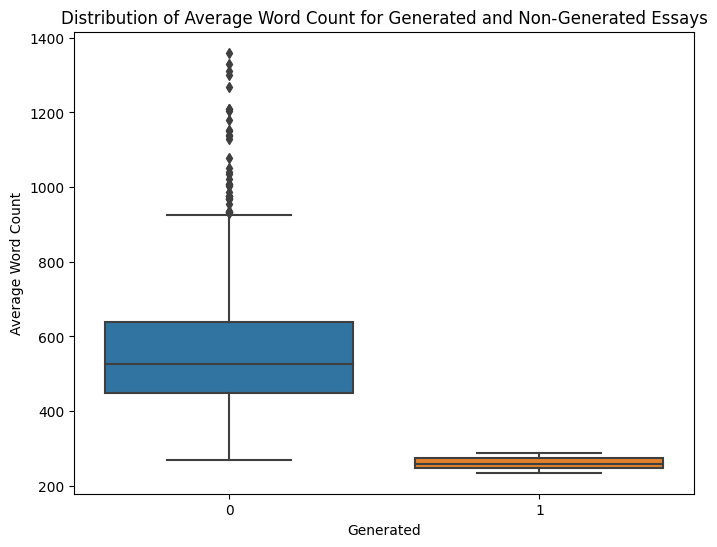

In [13]:
# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Apply the function to create a new 'word_count' column
train_essays['word_count'] = train_essays['text'].apply(word_count)

# Calculate the median word count for generated and non-generated essays
median_word_count = train_essays.groupby(['generated'])['word_count'].median().reset_index()
display(median_word_count)

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(x='generated', y='word_count', data=train_essays)
plt.title('Distribution of Average Word Count for Generated and Non-Generated Essays')
plt.xlabel('Generated')
plt.ylabel('Average Word Count')
plt.show()

<a id="most-common-words"></a>
## Most Common Words

Distinctive linguistic patterns emerge when comparing common words in student essays and those generated by LLMs.

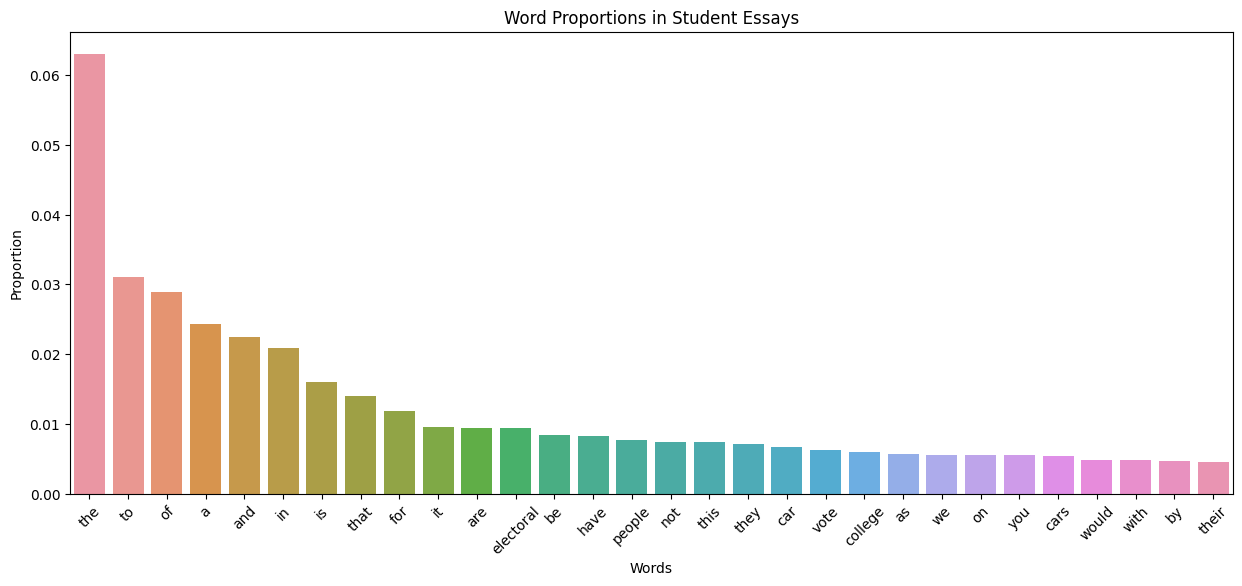

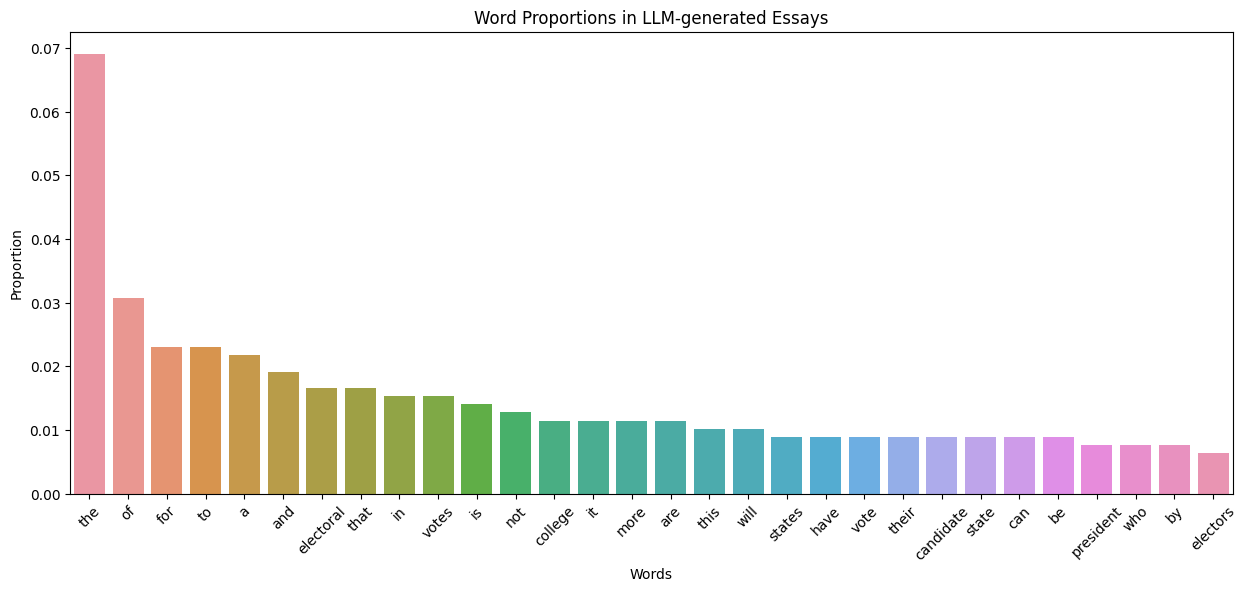

In [14]:
def calculate_word_proportions(text_series, num_words=30):
    """
    Calculate word proportions from a series of texts.

    Parameters:
    - text_series: Series of text data.
    - num_words: Number of top words to consider (default is 30).

    Returns:
    - A list of tuples containing words and their proportions.
    """
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    total_words = len(words)
    word_freq = Counter(words)
    word_proportions = [(word, freq / total_words) for word, freq in word_freq.most_common(num_words)]
    return word_proportions

def plot_bar_chart_proportions(data, x_label, y_label, title, rotation=45):
    """
    Plot a bar chart of word proportions using the given data.

    Parameters:
    - data: List of tuples containing x-axis and y-axis data.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - title: Title of the plot.
    - rotation: Rotation angle for x-axis labels (default is 45).
    """
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[item[0] for item in data], y=[item[1] for item in data])
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Calculate and plot word proportions for student essays
student_word_proportions = calculate_word_proportions(train_essays[train_essays['generated'] == 0]['text'])
plot_bar_chart_proportions(student_word_proportions, 'Words', 'Proportion', 'Word Proportions in Student Essays')

# Calculate and plot word proportions for LLM-generated essays
llm_word_proportions = calculate_word_proportions(train_essays[train_essays['generated'] == 1]['text'])
plot_bar_chart_proportions(llm_word_proportions, 'Words', 'Proportion', 'Word Proportions in LLM-generated Essays')

<a id="stop-word-count"></a>
## Stop Word Count

- Median stop word count for student essays: 250.0 words
- Median stop word count for llm-generated essays: 124.0 words

In [15]:
# Function to count stop words
def count_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    stop_words_count = sum(1 for word in words if word.lower() in stop_words)
    return stop_words_count

# Apply the function to create a new 'stop_word_count' column
train_essays['stop_word_count'] = train_essays['text'].apply(count_stop_words)

# Calculate the count of stop words for generated and non-generated essays
stop_word_count = train_essays.groupby(['generated'])['stop_word_count'].median().reset_index()
stop_word_count

,generated,stop_word_count
0,0,250.0
1,1,124.0


<a id="sentence-count"></a>
## Number of Sentences

- Median sentence count for student essays: 27.0 sentences
- Median sentence count for llm-generated essays: 11.0 sentences

In [16]:
# Define a function to count sentences
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Apply the function to create a new 'nr_sentences' column
train_essays['nr_sentences'] = train_essays['text'].apply(count_sentences)

# Calculate the mean number of sentences for generated and non-generated essays
mean_sentence_count = train_essays.groupby(['generated'])['nr_sentences'].median().reset_index()
mean_sentence_count

,generated,nr_sentences
0,0,27.0
1,1,11.0


<a id="clause-count"></a>
## Number of Clauses

- Median number of clauses for student essays: 22.54 clauses
- Median number of clauses  for llm-generated essays: 23.18 clauses

In [17]:
# Define a function to calculate sentence complexity based on clauses
def sentence_complexity_clauses(text):
    sentences = sent_tokenize(text)
    clause_counts = [len(TreebankWordTokenizer().tokenize(sentence)) for sentence in sentences]
    avg_clause_count = sum(clause_counts) / len(sentences)
    return round(avg_clause_count, 2)

# Apply the function to create a new 'sentence_complexity_clauses' column
train_essays['sentence_complexity_clauses'] = train_essays['text'].apply(sentence_complexity_clauses)

# Calculate the mean sentence complexity based on clauses for generated and non-generated essays
mean_sentence_complexity_clauses = train_essays.groupby(['generated'])['sentence_complexity_clauses'].median().reset_index()
mean_sentence_complexity_clauses

,generated,sentence_complexity_clauses
0,0,22.54
1,1,23.18


<a id="vocabulary-richness"></a>
## Voabulary Richness

TTR is the ratio of the number of unique words (types) to the total number of words (tokens) in a text.

- Median TTR for student essays: 0.43
- Median TTR for llm-generated essays: 0.47

In [18]:
# Preprocess the text by lowercasing, removing punctuation, and newline characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('\n', ' ')  # Remove newline characters and replace with a space
    return text

# Define a function to calculate type-token ratio (TTR)
def calculate_ttr(text):
    words = word_tokenize(text)
    total_tokens = len(words)
    unique_tokens = len(set(words))
    ttr = unique_tokens / total_tokens
    return ttr

# Calculate TTR and create a new 'ttr' column
train_essays['ttr'] = train_essays['text'].apply(preprocess_text).apply(calculate_ttr)

# Calculate the median TTR for generated and non-generated essays
median_ttr = train_essays.groupby(['generated'])['ttr'].median().reset_index()
median_ttr

,generated,ttr
0,0,0.434132
1,1,0.468085


<a id="paragraph-count"></a>
## Paragraph Count

- Median paragraph count for student essays: 5.6 paragraphs
- Median paragraph count for llm-generated essays: 11 paragraphs

In [19]:
# Define a function to analyze the average length of paragraphs
def average_paragraph_length(text):
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by two newline characters
    paragraph_lengths = [len(sent_tokenize(paragraph)) for paragraph in paragraphs if paragraph.strip()]  # Exclude empty paragraphs
    avg_paragraph_length = sum(paragraph_lengths) / len(paragraphs)
    return round(avg_paragraph_length, 2)

# Apply the function to create a new 'avg_paragraph_length' column
train_essays['avg_paragraph_length'] = train_essays['text'].apply(average_paragraph_length)

# Calculate the mean average paragraph length for generated and non-generated essays
median_paragraph_length = train_essays.groupby(['generated'])['avg_paragraph_length'].median().reset_index()
median_paragraph_length

,generated,avg_paragraph_length
0,0,5.6
1,1,11.0


<a id="digit-representation"></a>
## Digit Representation

Examine the ratio of numerals and word representations of numbers within the essays.
- Student written essays use numerals over words to represent numbers more often.

In [20]:
# Function to count occurrences of numerals and words representing numbers
def count_numerals_vs_words(text):
    numerals_count = len(re.findall(r'\b\d+\b', text))  # Counting numerals using regex
    words_count = len(re.findall(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b', text, flags=re.IGNORECASE))  # Counting words representing numbers

    return numerals_count, words_count

# Apply the function to create new columns 'numerals_count' and 'words_count'
train_essays[['numerals_count', 'words_count']] = train_essays['text'].apply(count_numerals_vs_words).apply(pd.Series)

# Calculate the ratio of numerals to words for each essay
train_essays['numerals_to_words_ratio'] = train_essays['numerals_count'] / (train_essays['words_count'] + 1)  # Adding 1 to avoid division by zero

# Calculate the ratio of numerals to words  for generated and non-generated essays
numerals_to_words_ratio = train_essays.groupby(['generated'])['numerals_to_words_ratio'].mean().reset_index()
numerals_to_words_ratio

,generated,numerals_to_words_ratio
0,0,2.177644
1,1,0.500000


<a id="readability-measures"></a>
## Readability Measures

### Flesch-Kincaid Grade Level

The Flesch-Kincaid Grade Level is a readability score based on sentence and word length. It estimates the years of education a person needs to understand a piece of writing. The formula is given by:
$$0.39 \left( \frac{\text{total words}}{\text{total sentences}} \right) + 11.8 \left( \frac{\text{total syllables}}{\text{total words}} \right) - 15.59$$

### Gunning Fog Index

The Gunning Fog Index assesses the complexity of written content based on the number of complex words and sentence length. The formula is given by:
$$0.4 \left( \frac{\text{total words}}{\text{total sentences}} + 100 \left( \frac{\text{complex words}}{\text{total words}} \right) \right)$$

### Coleman-Liau Index

The Coleman-Liau Index is a readability score that relies on characters instead of syllables. It considers the number of letters, words, and sentences. The formula is given by:
$$0.0588 \left( \frac{\text{total letters}}{\text{total words}} \times 100 \right) - 0.296 \left( \frac{\text{total sentences}}{\text{total words}} \times 100 \right) - 15.8$$

### SMOG Index

The SMOG Index evaluates text complexity based on the number of complex words and sentence length. The formula is given by:
$$1.0430 \sqrt{30 \left( \frac{\text{complex words}}{\text{total sentences}} \right) + 3.1291} + 3.4072$$

### Automated Readability Index (ARI)

The Automated Readability Index (ARI) assesses text complexity based on characters per word, words per sentence, and a constant. The formula is given by:
$$4.71 \left( \frac{\text{total letters}}{\text{total words}} \right) + 0.5 \left( \frac{\text{total words}}{\text{total sentences}} \right) - 21.43$$

### Simple Measure of Gobbledygook (SMOG)

The SMOG Index is another readability formula that estimates the years of education a person needs to understand a piece of writing. The formula is similar to the Gunning Fog Index.

### Dale-Chall Readability Formula

The Dale-Chall Readability Formula considers the number of difficult words and overall sentence length. The formula is given by:
$$0.1579 \left( \frac{\text{difficult words}}{\text{total words}} \times 100 \right) + 0.0496 \left( \frac{\text{total words}}{\text{total sentences}} \times 100 \right) + 3.6365 \, \text{(if difficult words > 5\%)}$$

### Linsear Write Formula

The Linsear Write Formula uses the number of simple and complex words to estimate readability. The formula is given by:
$$0.6 \left( \frac{\text{complex words}}{\text{total sentences}} \right) + 0.4 \left( \frac{\text{total words}}{\text{total sentences}} \right)$$

### FORCAST Readability Formula

The FORCAST Readability Formula calculates reading ease based on the number of one-syllable, two-syllable, and complex words. The formula is given by:
$$20 - \left( \frac{\text{difficult words}}{\text{total words}} \times 100 \right)$$

,coleman_liau_index,smog_index,automated_readability_index,dale_chall_readability_formula,linsear_write_formula,forcast_readability_formula
0,6.53,12.82,11.59,9.57,13.01,-8.57
1,7.20,12.92,7.95,9.62,9.39,-11.75
2,7.51,13.27,7.37,8.33,8.74,-4.23
3,5.85,11.44,5.86,8.68,7.97,-6.58
4,5.15,12.08,6.26,8.70,9.07,-6.01


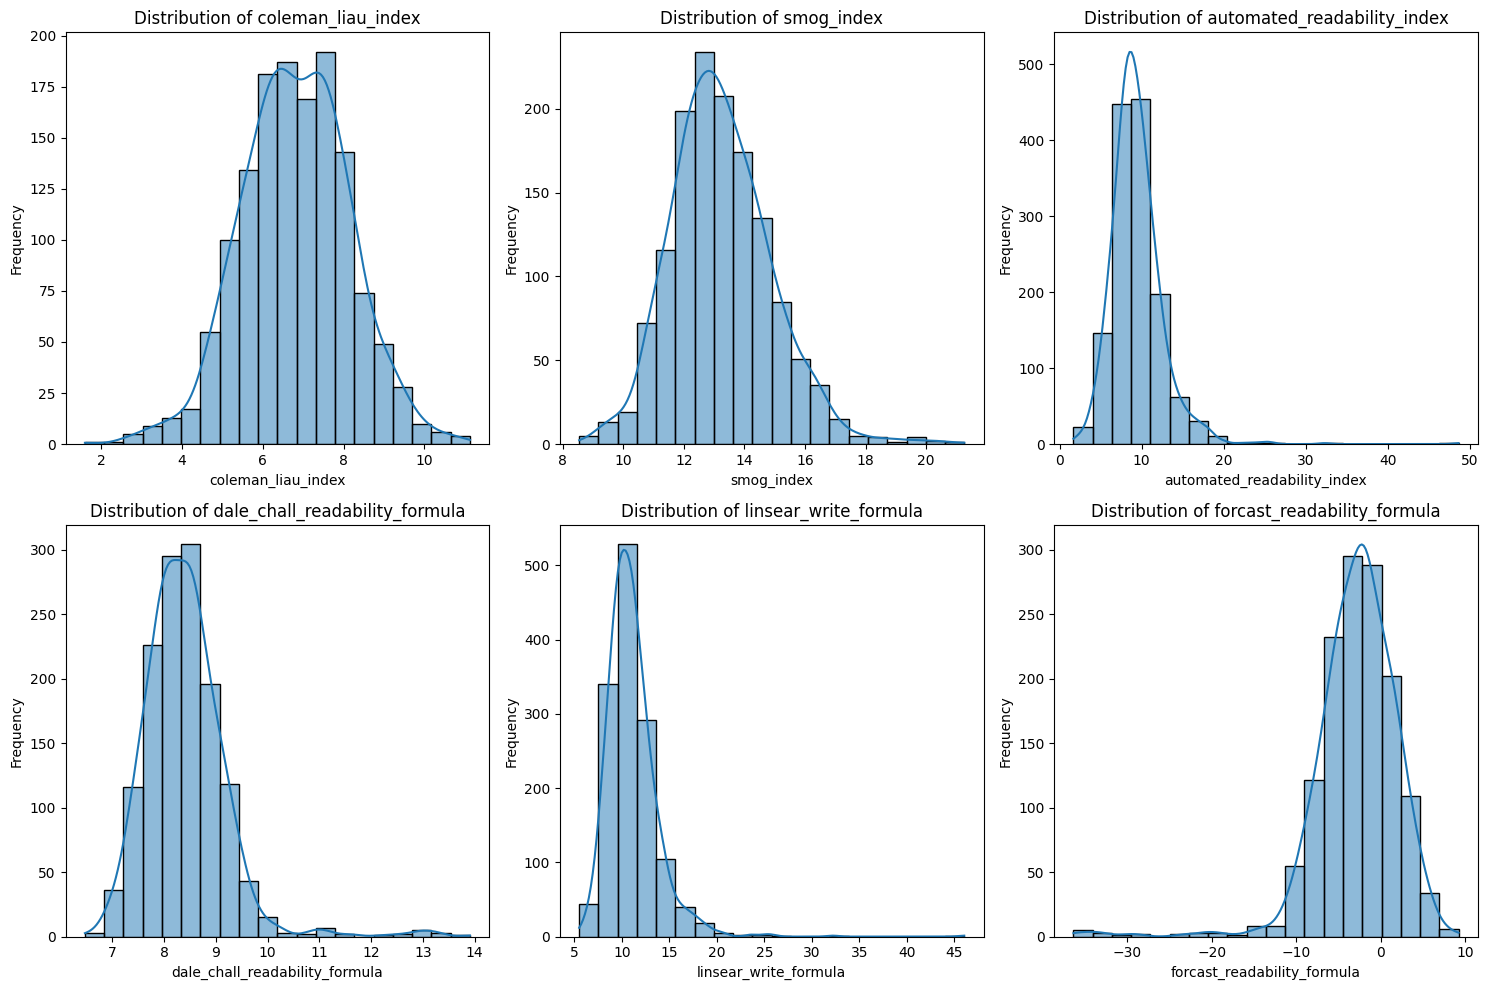

In [21]:
# Function to count syllables in a word
def syllable_count(word):
    if word.lower() in prondict:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in prondict[word.lower()]])
    else:
        return max(1, sum(1 for char in word if char.lower() in 'aeiou'))

# Function for Flesch-Kincaid Grade Level
def flesch_kincaid_grade_level(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    total_words = len(words)
    total_sentences = len(sentences)
    total_syllables = sum(syllable_count(word) for word in words)

    if total_words > 0 and total_sentences > 0:
        fk_grade_level = 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59
        return round(fk_grade_level, 2)
    else:
        return 0.0

# Function for Gunning Fog Index
def gunning_fog_index(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        fog_index = 0.4 * ((total_words / total_sentences) + 100 * (complex_words / total_words))
        return round(fog_index, 2)
    else:
        return 0.0

# Function for Coleman-Liau Index
def coleman_liau_index(text):
    letters = [char for char in text if char.isalpha()]
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_letters = len(letters)
    total_words = len(words)
    total_sentences = len(sentences)

    if total_words > 0 and total_sentences > 0:
        cl_index = 0.0588 * (total_letters / total_words * 100) - 0.296 * (total_sentences / total_words * 100) - 15.8
        return round(cl_index, 2)
    else:
        return 0.0

# Function for SMOG Index
def smog_index(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        smog_index = 1.0430 * (30 * (complex_words / total_sentences) + 3.1291) ** 0.5 + 3.4072
        return round(smog_index, 2)
    else:
        return 0.0

# Function for Automated Readability Index (ARI)
def automated_readability_index(text):
    letters = [char for char in text if char.isalpha()]
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_letters = len(letters)
    total_words = len(words)
    total_sentences = len(sentences)

    if total_words > 0 and total_sentences > 0:
        ari = 4.71 * (total_letters / total_words) + 0.5 * (total_words / total_sentences) - 21.43
        return round(ari, 2)
    else:
        return 0.0

# Function for Simple Measure of Gobbledygook (SMOG)
def smog_index(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        smog_index = 1.0430 * (30 * (complex_words / total_sentences) + 3.1291) ** 0.5 + 3.4072
        return round(smog_index, 2)
    else:
        return 0.0

# Function for Dale-Chall Readability Formula
def dale_chall_readability_formula(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    difficult_words = count_difficult_words(text)

    if total_words > 0 and total_sentences > 0:
        dale_chall_score = 0.1579 * (difficult_words / total_words * 100) + 0.0496 * (total_words / total_sentences)
        if difficult_words / total_words > 0.05:
            dale_chall_score += 3.6365
        return round(dale_chall_score, 2)
    else:
        return 0.0

# Function for Linsear Write Formula
def linsear_write_formula(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        lwf = 0.6 * (complex_words / total_sentences) + 0.4 * (total_words / total_sentences)
        return round(lwf, 2)
    else:
        return 0.0

# Function for FORCAST Readability Formula
def forcast_readability_formula(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    difficult_words = count_difficult_words(text)

    if total_words > 0 and total_sentences > 0:
        forcast_score = 20 - (difficult_words / total_words * 100)
        return round(forcast_score, 2)
    else:
        return 0.0

# Function to count complex words (syllables > 2)
def count_complex_words(text):
    words = word_tokenize(text)
    return sum(1 for word in words if syllable_count(word) > 2)

# Function to count difficult words (not in Dale-Chall word list)
def count_difficult_words(text):
    words = word_tokenize(text)
    difficult_words = [word.lower() for word in words if word.lower() not in dale_chall_word_list]
    return len(difficult_words)

# Calculate readability scores for each essay
train_essays['coleman_liau_index'] = train_essays['text'].apply(coleman_liau_index)
train_essays['smog_index'] = train_essays['text'].apply(smog_index)
train_essays['automated_readability_index'] = train_essays['text'].apply(automated_readability_index)
train_essays['dale_chall_readability_formula'] = train_essays['text'].apply(dale_chall_readability_formula)
train_essays['linsear_write_formula'] = train_essays['text'].apply(linsear_write_formula)
train_essays['forcast_readability_formula'] = train_essays['text'].apply(forcast_readability_formula)

# Display the calculated readability scores
readability_scores = train_essays[['coleman_liau_index', 'smog_index', 'automated_readability_index', 'dale_chall_readability_formula', 'linsear_write_formula', 'forcast_readability_formula']]
display(readability_scores.head())

# Select the readability scores for visualization
selected_scores = ['coleman_liau_index', 'smog_index', 'automated_readability_index',
                   'dale_chall_readability_formula', 'linsear_write_formula', 'forcast_readability_formula']

# Plot histograms for each readability score
plt.figure(figsize=(15, 10))
for score in selected_scores:
    plt.subplot(2, 3, selected_scores.index(score) + 1)
    sns.histplot(train_essays[score], bins=20, kde=True)
    plt.title(f'Distribution of {score}')
    plt.xlabel(score)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<a id="parts-of-speech"></a>
## Parts of Speech

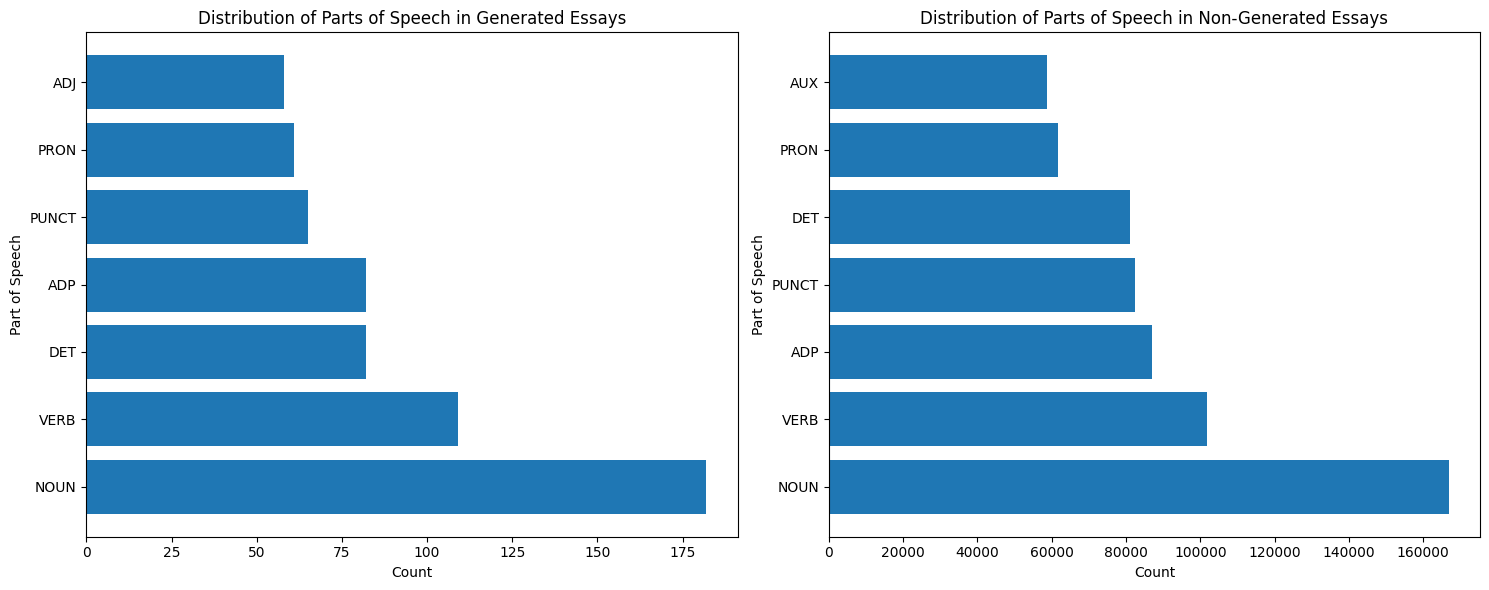

In [22]:
# Function to extract parts of speech
def extract_pos(text):
    doc = nlp(text)
    # Perform POS analysis
    pos_analysis = [token.pos_ for token in doc]
    return pos_analysis

# Apply the function to create 'parts_of_speech' columns for generated and non-generated essays
parts_of_speech_generated = train_essays[train_essays['generated'] == 1]['text'].apply(extract_pos)
parts_of_speech_non_generated = train_essays[train_essays['generated'] == 0]['text'].apply(extract_pos)

# Flatten the lists of parts of speech
all_pos_generated = Counter([pos for sublist in parts_of_speech_generated for pos in sublist])
all_pos_non_generated = Counter([pos for sublist in parts_of_speech_non_generated for pos in sublist])

# Plot the distribution of parts of speech for generated essays
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
x,y = list(map(list,zip(*all_pos_generated.most_common(7))))
plt.barh(x, y)
plt.title('Distribution of Parts of Speech in Generated Essays')
plt.xlabel('Count')
plt.ylabel('Part of Speech')

# Plot the distribution of parts of speech for non-generated essays
plt.subplot(1, 2, 2)
x,y = list(map(list,zip(*all_pos_non_generated.most_common(7))))
plt.barh(x, y)
plt.title('Distribution of Parts of Speech in Non-Generated Essays')
plt.xlabel('Count')
plt.ylabel('Part of Speech')

# Adjust layout for better presentation
plt.tight_layout()
plt.show()

<a id="ner"></a>
## Named Entity Recognition (NER)

NER is a key NLP task for identifying and categorizing entities (e.g., persons, organizations, locations) in text, extracting structured information. It enhances context understanding in applications like information retrieval and question answering

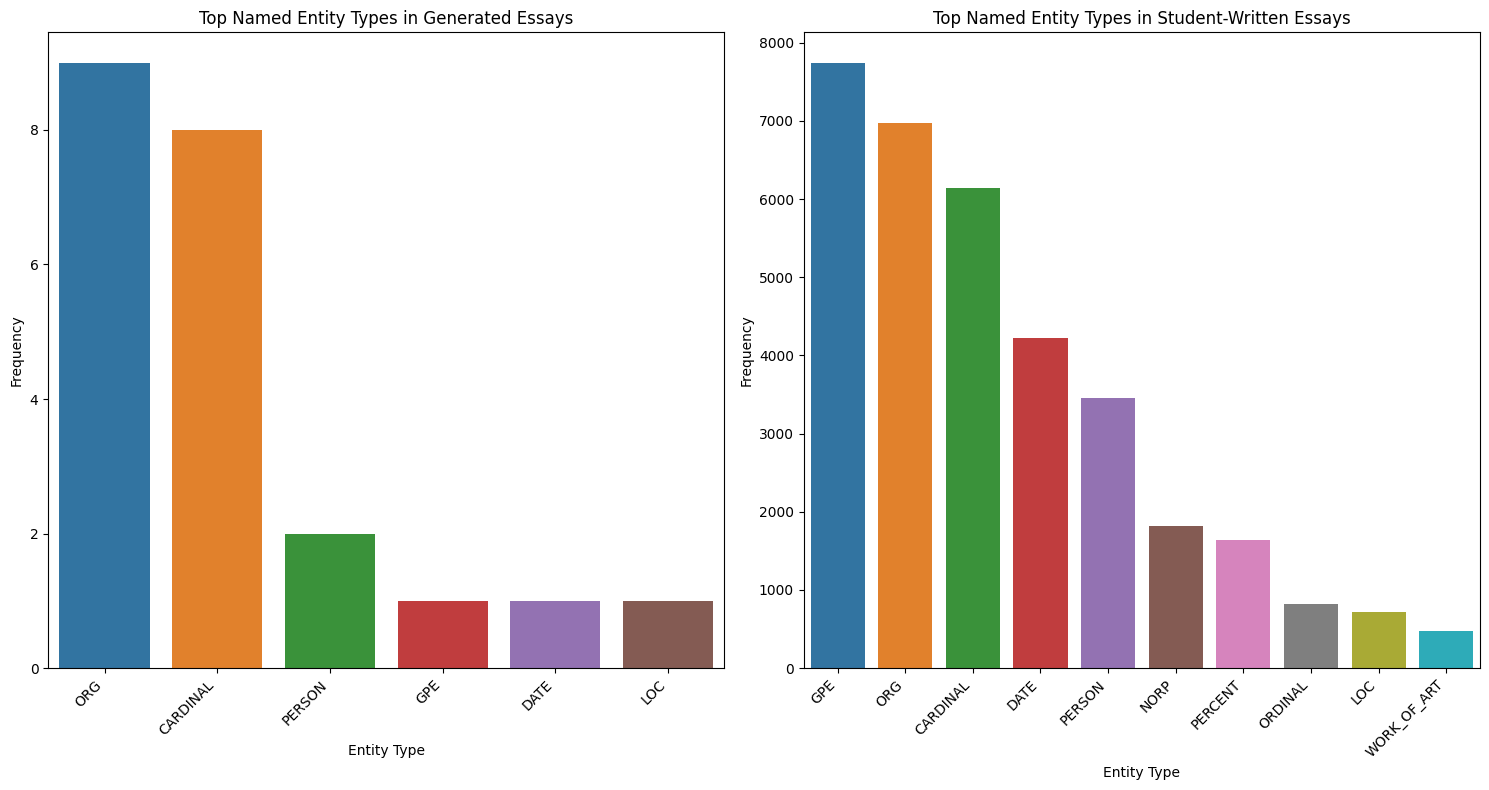

In [23]:
# Function to group named entities into predefined entity types
def group_entities_by_type(text):
    doc = nlp(text)
    entity_groups = defaultdict(int)

    for ent in doc.ents:
        entity_groups[ent.label_] += 1
    return entity_groups

# Apply the function to create a new 'entity_groups' column
train_essays['entity_groups'] = train_essays['text'].apply(group_entities_by_type)

# Separate data for generated and student-written essays
generated_entity_groups = train_essays[train_essays['generated'] == 1]['entity_groups']
student_entity_groups = train_essays[train_essays['generated'] == 0]['entity_groups']

# Combine counts across generated essays
generated_all_entity_groups = defaultdict(int)
for entity_group in generated_entity_groups:
    for entity_type, count in entity_group.items():
        generated_all_entity_groups[entity_type] += count

# Combine counts across student-written essays
student_all_entity_groups = defaultdict(int)
for entity_group in student_entity_groups:
    for entity_type, count in entity_group.items():
        student_all_entity_groups[entity_type] += count

# Select the top N entity types to display for generated essays
top_generated_entity_types = Counter(generated_all_entity_groups).most_common(10)

# Select the top N entity types to display for student-written essays
top_student_entity_types = Counter(student_all_entity_groups).most_common(10)

# Plot separate bar charts for each category
plt.figure(figsize=(15, 8))

# Plot for generated essays
plt.subplot(1, 2, 1)
sns.barplot(x=[entity_type[0] for entity_type in top_generated_entity_types], y=[entity_type[1] for entity_type in top_generated_entity_types])
plt.title('Top Named Entity Types in Generated Essays')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Plot for student-written essays
plt.subplot(1, 2, 2)
sns.barplot(x=[entity_type[0] for entity_type in top_student_entity_types], y=[entity_type[1] for entity_type in top_student_entity_types])
plt.title('Top Named Entity Types in Student-Written Essays')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Co-occurrence Matrix of NER

In [24]:
def extract_named_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

train_essays['named_entities'] = train_essays['text'].apply(extract_named_entities)

# Define window size
window_size = 3

# Create co-occurrence matrix
co_occurrence_matrix = Counter()

# Iterate over documents
for document_id, entities, generated in train_essays[['prompt_id', 'named_entities', 'generated']].itertuples(index=False):
    # Generate combinations of entities within the window size
    entity_combinations = list(itertools.combinations(entities, 2))

    # Update co-occurrence matrix based on the 'generated' class
    for pair in entity_combinations:
        co_occurrence_matrix[(pair, generated)] += 1

# Normalize the matrix (optional)
total_occurrences = sum(co_occurrence_matrix.values())
normalized_matrix = {pair: count / total_occurrences for pair, count in co_occurrence_matrix.items()}

# Print the result
list(normalized_matrix.items())[:10]

[((('the 1900s', 'Henry Ford'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'first'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'German Suburb'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'Elizabeth Rosenthal'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'Shanghai'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'Chicago'), 0), 1.859361606785926e-06),
 ((('the 1900s', '12 percent'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'Europe'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'up to 50 percent'), 0), 1.859361606785926e-06),
 ((('the 1900s', 'the United States'), 0), 1.859361606785926e-06)]

<a id="semantic-analysis"></a>
## Semantic Analaysis using Cosine similarity

,generated,text,instructions,cosine_similarity
0,0,Cars. Cars have been around since they became ...,Write an explanatory essay to inform fellow ci...,0.107439
1,0,Transportation is a large necessity in most co...,Write an explanatory essay to inform fellow ci...,0.089414
2,0,"""America's love affair with it's vehicles seem...",Write an explanatory essay to inform fellow ci...,0.129088
3,0,How often do you ride in a car? Do you drive a...,Write an explanatory essay to inform fellow ci...,0.148044
4,0,Cars are a wonderful thing. They are perhaps o...,Write an explanatory essay to inform fellow ci...,0.099936
...,...,...,...,...
1373,0,The Electoral College was originally establish...,Write a letter to your state senator in which ...,0.147412
1374,0,"Dear senator, I think that the presidential el...",Write a letter to your state senator in which ...,0.170241
1375,0,The electoral college is a group of electors t...,Write a letter to your state senator in which ...,0.173587
1376,0,An electoral College compromises between elect...,Write a letter to your state senator in which ...,0.172460


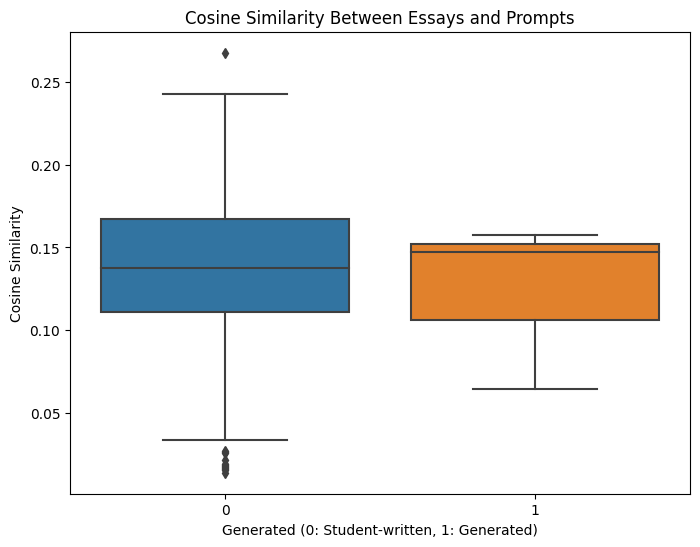

,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0,1375.0,0.138076,0.036681,0.013830,0.111168,0.137747,0.166943,0.267725
1,3.0,0.123100,0.050947,0.064564,0.105929,0.147294,0.152368,0.157441


T-test Results:
	T-statistic: -0.705909761767645
	P-value: 0.4803637503668001
There is no statistically significant difference in cosine similarity scores.


In [25]:
# Merge essays with prompts based on 'prompt_id'
merged_df = pd.merge(train_prompts, train_essays, on='prompt_id', how='inner')

# Tokenize and process essay and prompt text
merged_df['essay_tokens'] = merged_df['text'].apply(lambda text: [token.text.lower() for token in nlp(text)])
merged_df['prompt_tokens'] = merged_df['instructions'].apply(lambda text: [token.text.lower() for token in nlp(text)])

tfidf_vectorizer = TfidfVectorizer()
essay_tfidf = tfidf_vectorizer.fit_transform(merged_df['text'])
prompt_tfidf = tfidf_vectorizer.transform(merged_df['instructions'])

similarity_scores = cosine_similarity(essay_tfidf, prompt_tfidf)
merged_df['cosine_similarity'] = similarity_scores.diagonal()

# Display the result
display(merged_df[['generated', 'text', 'instructions', 'cosine_similarity']])

# Box plot for visualizing the distribution of cosine similarity scores
plt.figure(figsize=(8, 6))
sns.boxplot(x='generated', y='cosine_similarity', data=merged_df)
plt.title('Cosine Similarity Between Essays and Prompts')
plt.xlabel('Generated (0: Student-written, 1: Generated)')
plt.ylabel('Cosine Similarity')
plt.show()

# Statistical summary
summary_stats = merged_df.groupby('generated')['cosine_similarity'].describe()
display(summary_stats)

# Separate the data into generated and student-written essays
generated_scores = merged_df[merged_df['generated'] == 1]['cosine_similarity']
student_scores = merged_df[merged_df['generated'] == 0]['cosine_similarity']

# Perform a t-test
t_stat, p_value = ttest_ind(generated_scores, student_scores)

# Display the t-test results
print(f'T-test Results:\n\tT-statistic: {t_stat}\n\tP-value: {p_value}')

# Interpret the results
if p_value < 0.05:
    print('The difference in cosine similarity scores is statistically significant.')
else:
    print('There is no statistically significant difference in cosine similarity scores.')

<a id="topic-modeling"></a>
## Topic modeling

LDA is a probabilistic model that represents documents as mixtures of topics, and topics as mixtures of words. The key variables in LDA are:

- **Documents (`D`):** A collection of documents, where each document is represented as a bag-of-words.

- **Topics (`K`):** The predefined number of topics in the corpus.

- **Words (`V`):** The vocabulary of the entire corpus.

The generative process of LDA can be summarized as follows:

1. For each document `d`:
   - Choose a distribution over topics (`theta_d`) from a Dirichlet distribution.
   - For each word `w` in the document:
     - Choose a topic `z` from the distribution over topics (`theta_d`).
     - Choose a word `w` from the distribution over words for the selected topic (`z`).

2. The parameters of the model are:
   - **alpha (`α`):** The parameter of the Dirichlet prior on the per-document topic distributions.
   - **beta (`β`):** The parameter of the Dirichlet prior on the per-topic word distribution.

The joint distribution of LDA is given by:

$$ p(\text{documents, topics, words, alpha, beta}) = p(\text{alpha}) \prod_{d=1}^{D} \left( p(\text{theta_d | alpha}) \prod_{n=1}^{N_d} p(\text{z_{d,n} | theta_d}) p(\text{w_{d,n} | z_{d,n}, beta}) \right)$$

Here:
- $ p(\text{theta_d | alpha}) $ is the Dirichlet distribution for the topic proportions in document `d`.
- $ p(\text{z_{d,n} | theta_d}) $ is the multinomial distribution for the topic assignment of word `n` in document `d`.
- $ p(\text{w_{d,n} | z_{d,n}, beta}) $ is the multinomial distribution for the word assignment of word `n` in document `d`.

The goal of LDA is to infer the posterior distribution of topics given the observed documents, which is done through techniques like variational inference or Gibbs sampling.


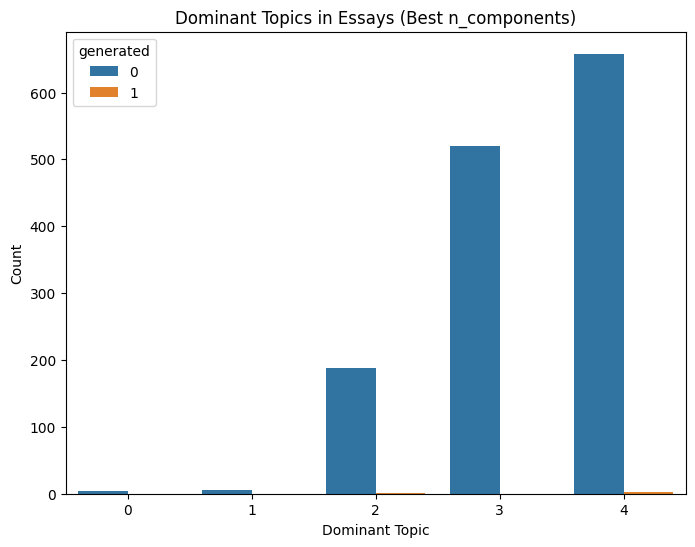

T-test Results (Best n_components):
	T-statistic: 1.4574709624931617
	P-value: 0.14521459467072573
There is no statistically significant difference in topic-related features for the best n_components.


In [26]:
# Assuming 'texts' is a list of your text data
texts = merged_df['text']
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(texts)

# Train LDA with the chosen n_components
lda_best = LatentDirichletAllocation(n_components=5, random_state=42)
topics_best = lda_best.fit_transform(dtm)

# Add topic-related features to the DataFrame
merged_df['dominant_topic_best'] = topics_best.argmax(axis=1)
merged_df['topic_proportion_best_1'] = topics_best[:, 0]

# Visualize the dominant topics for generated and student-written essays
plt.figure(figsize=(8, 6))
sns.countplot(x='dominant_topic_best', hue='generated', data=merged_df)
plt.title('Dominant Topics in Essays (Best n_components)')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.show()

# Perform a t-test on the best n_components
t_stat_best, p_value_best = ttest_ind(merged_df[merged_df['generated'] == 1]['topic_proportion_best_1'],
                                      merged_df[merged_df['generated'] == 0]['topic_proportion_best_1'])

# Display the t-test results for the best n_components
print(f'T-test Results (Best n_components):\n\tT-statistic: {t_stat_best}\n\tP-value: {p_value_best}')

# Interpret the results for the best n_components
if p_value_best < 0.05:
    print('The difference in topic-related features is statistically significant for the best n_components.')
else:
    print('There is no statistically significant difference in topic-related features for the best n_components.')

<a id="sentiment-polarity"></a>
## Sentiment Polarity

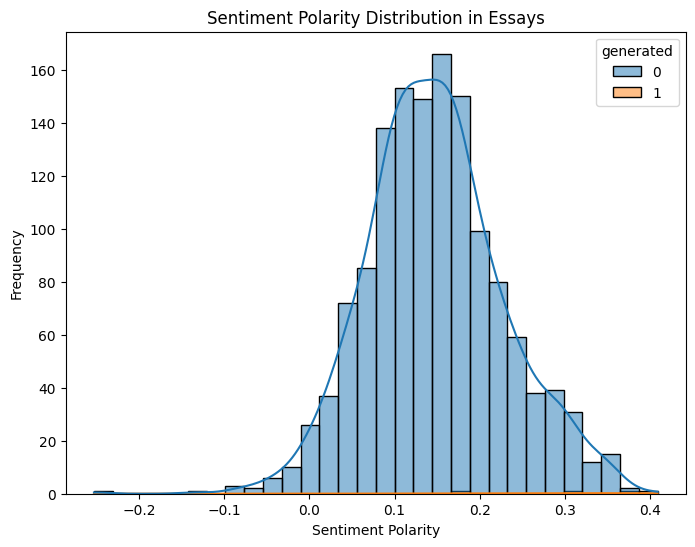

In [27]:
# Function to calculate sentiment polarity
def calculate_sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the function to create a new 'sentiment_polarity' column
train_essays['sentiment_polarity'] = train_essays['text'].apply(calculate_sentiment_polarity)

# Visualize the distribution of sentiment polarity for generated and student-written essays
plt.figure(figsize=(8, 6))
sns.histplot(data=train_essays, x='sentiment_polarity', hue='generated', bins=30, kde=True)
plt.title('Sentiment Polarity Distribution in Essays')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()